In [1]:
#Importing necessary libraries
import pandas as pd 
import numpy as np


In [2]:
# Load the datasets
train_data = pd.read_csv('C:/Users/previ/OneDrive/Documents/TRAIN_TWEET.csv')
test_data = pd.read_csv('C:/Users/previ/OneDrive/Documents/TEST_TWEET.csv')

# View the first few rows of the training data
print(train_data.head())


   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


In [3]:
# Check the size of the datasets
print(f"Training data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Training data size: (31962, 3)
Test data size: (17197, 2)


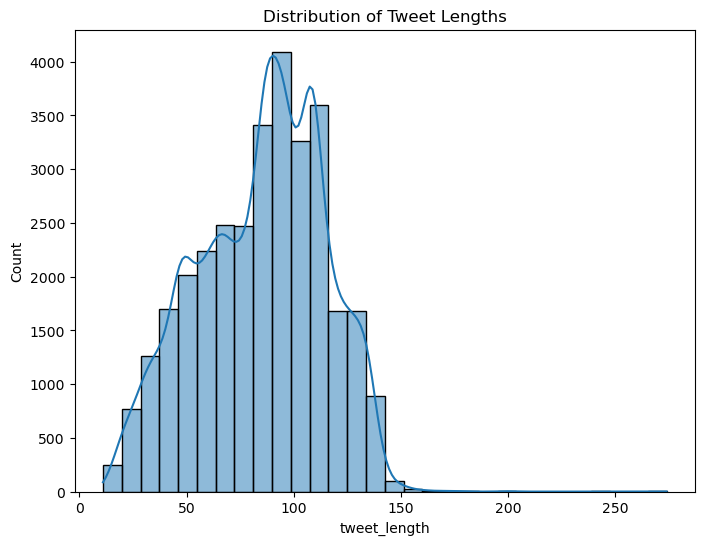

In [4]:
# Add a new column with the length of each tweet
train_data['tweet_length'] = train_data['tweet'].apply(len)

# Visualize the distribution of tweet lengths
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(train_data['tweet_length'], bins=30, kde=True)
plt.title("Distribution of Tweet Lengths")
plt.show()

In [5]:
#cleaning the text data
import re
def clean_text(text):
    # Remove URLs, special characters, and digits
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text

# Apply the cleaning function to the 'tweet' column
train_data['cleaned_tweet'] = train_data['tweet'].apply(clean_text)
test_data['cleaned_tweet'] = test_data['tweet'].apply(clean_text)


In [6]:
from sklearn.model_selection import train_test_split

# Separate features (tweets) and labels (hate or non-hate)
X = train_data['cleaned_tweet']  # Features
y = train_data['label']          # Target labels

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Fit and transform the training data, then transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize Logistic Regression with balanced class weights
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

# Predict on the test set
log_reg_preds = log_reg.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression Results:")
print(classification_report(y_test, log_reg_preds))
print("Accuracy:", accuracy_score(y_test, log_reg_preds))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      5937
           1       0.48      0.84      0.61       456

    accuracy                           0.92      6393
   macro avg       0.73      0.88      0.78      6393
weighted avg       0.95      0.92      0.93      6393

Accuracy: 0.9227279837322071


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


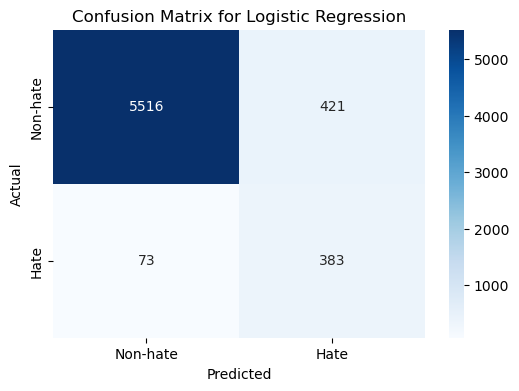

In [16]:
# Confusion Matrix for Logistic Regression
log_reg_cm = confusion_matrix(y_test, log_reg_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-hate', 'Hate'], yticklabels=['Non-hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


In [9]:
# Calculate scale_pos_weight as ratio of majority to minority class in training set
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


In [12]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/fe/df/e3a1f3f008db8d2b199ded2168014c7784b8027714b74d802c892815fd72/xgboost-2.1.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 435.7 kB/s eta 0:04:47
   ---------------------------------------- 0.1/124.9 MB 980.4 kB/s eta 0:02:08
   ---------------------------------------- 0.2/124.9 MB 1.1 MB/s eta 0:01:49
   ---------------------------------------- 0.3/124.9 MB 1.4 MB/s eta 0:01:32
   ---------------------------------------- 0.4/124.9 MB 1.8 MB/s eta 0:01:12
   ---------------------------------------- 0.5/124.9 MB 1.9 MB/s eta 0:01:06
   ---------------------------------------- 0.6/124.9 MB 1.7 MB/s eta 0:01:12
   ---------------------------------------- 0.7/124.9 MB 1.8 MB/s eta 0:01:08
   ---------------------------------------- 0.8/124.9 MB 2.0 MB/s eta 0:01:04
   ---------------

In [13]:
from xgboost import XGBClassifier

# Initialize XGBoost with the scale_pos_weight parameter
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_tfidf, y_train)

# Predict on the test set
xgb_preds = xgb.predict(X_test_tfidf)

# Evaluate the model
print("XGBoost Results:")
print(classification_report(y_test, xgb_preds))
print("Accuracy:", accuracy_score(y_test, xgb_preds))


C:\Users\previ\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      5937
           1       0.43      0.72      0.54       456

    accuracy                           0.91      6393
   macro avg       0.70      0.82      0.74      6393
weighted avg       0.94      0.91      0.92      6393

Accuracy: 0.9111528234005944


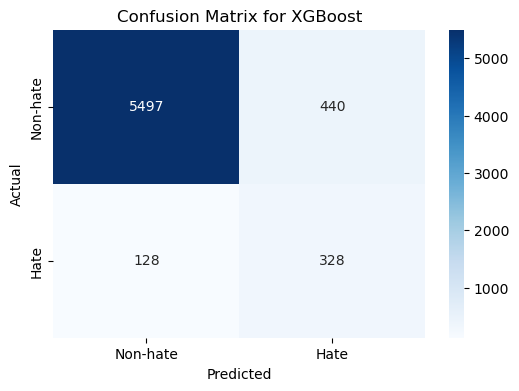

In [17]:
# Confusion Matrix for XGBoost
xgb_cm = confusion_matrix(y_test, xgb_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-hate', 'Hate'], yticklabels=['Non-hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()
